In [39]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [26]:
%run '/Users/sabanejad/Projects/demand-response/functions.py'

In [27]:
temp = pd.read_csv('POWER_Point_Hourly_20120101_20140228_051d5072N_000d1276E_LST_no_header.csv', usecols=['YEAR', 'MO', 'DY', 'HR', 'T2M'])
temp.columns = ['year', 'month', 'day', 'hour', 'temp']
temp['DT'] = pd.to_datetime(temp[['year', 'month', 'day', 'hour']])
temp.set_index('DT', inplace=True)

# remove feb 29, 2012
temp = temp.loc[(temp.index != '2012-02-29')]

temp.head()

,year,month,day,hour,temp
DT,,,,,
2012-01-01 00:00:00,2012,1,1,0,11.12
2012-01-01 01:00:00,2012,1,1,1,11.06
2012-01-01 02:00:00,2012,1,1,2,11.00
2012-01-01 03:00:00,2012,1,1,3,10.99
2012-01-01 04:00:00,2012,1,1,4,10.96


In [28]:
tariffs = pd.read_parquet('tariffs.gzip')

lows = np.array(tariffs.index[tariffs['tariff'] == 'Low'], dtype=np.datetime64)
normals = np.array(tariffs.index[tariffs['tariff'] == 'Normal'], dtype=np.datetime64)
highs = np.array(tariffs.index[tariffs['tariff'] == 'High'], dtype=np.datetime64)

lows_2012 = lows - np.timedelta64(365, 'D')
normals_2012 = normals - np.timedelta64(365, 'D')
highs_2012 = highs - np.timedelta64(365, 'D')

In [29]:
lows_2014 = lows + np.timedelta64(365, 'D')
normals_2014 = normals + np.timedelta64(365, 'D')
highs_2014 = highs + np.timedelta64(365, 'D')

In [30]:
total_acorn = pd.read_parquet('total_acorn.gzip')

affluent = total_acorn.loc[total_acorn['acorn_category'] == 'Affluent']['house_id']
comfortable = total_acorn.loc[total_acorn['acorn_category'] == 'Comfortable']['house_id']
adversity = total_acorn.loc[total_acorn['acorn_category'] == 'Adversity']['house_id']

In [31]:
total_usage_2012 = pd.read_parquet('total_usage_2012.gzip')
total_usage_2013 = pd.read_parquet('total_usage_2013.gzip')
total_usage_2014 = pd.read_parquet('total_usage_2014.gzip')

- alpha_2012 X = beta_2012
- alpha_2013 X = beta_cf_2013

dims: 
    (t x n_c) (n_c x n_t) = (t x n_t)
    
- clean data for each year over the house dimension
- intersection of houses between the two years after cleaning
- intersection of time between the control and treatment in the _same_ year

In [535]:
total_usage_2012_second_half = total_usage_2012.loc[(total_usage_2012['date_time'].dt.normalize() >= '2012-07-01')]
total_usage_2013_second_half = total_usage_2013.loc[(total_usage_2013['date_time'].dt.normalize() >= '2013-07-01')]

In [918]:
df_2012_treatment_second_half, df_2012_control_second_half = split_t_c(total_usage_2012_second_half)
df_2013_treatment_second_half, df_2013_control_second_half = split_t_c(total_usage_2013_second_half)

In [ ]:
# usage_2012_lows_comfortable = get_subset(total_usage_2012_second_half, lows_2012, comfortable)
# usage_2013_lows_comfortable = get_subset(total_usage_2013_second_half, lows, comfortable)

# usage_2012_normals_comfortable = get_subset(total_usage_2012_second_half, normals_2012, comfortable)
# usage_2013_normals_comfortable = get_subset(total_usage_2013_second_half, normals, comfortable)

# usage_2012_highs_comfortable = get_subset(total_usage_2012_second_half, highs_2012, comfortable)
# usage_2013_highs_comfortable = get_subset(total_usage_2013_second_half, highs, comfortable)

# usage_2012_normals_affluent = get_subset(total_usage_2012_second_half, normals_2012, affluent)
# usage_2013_normals_affluent = get_subset(total_usage_2013_second_half, normals, affluent)

# usage_2012_normals_adversity = get_subset(total_usage_2012_second_half, normals_2012, adversity)
# usage_2013_normals_adversity = get_subset(total_usage_2013_second_half, normals, adversity)

In [1169]:
df_2012_treatment_second_half, df_2012_control_second_half = split_t_c(usage_2012_normals_comfortable)
df_2013_treatment_second_half, df_2013_control_second_half = split_t_c(usage_2013_normals_comfortable)

In [1170]:
a_2012_second_half_, b_2012_second_half_, a_2013_second_half_, b_2013_second_half_ = get_matrices(df_2012_treatment_second_half, 
                                                                                              df_2012_control_second_half, 
                                                                                              df_2013_treatment_second_half, 
                                                                                              df_2013_control_second_half, 0.01)

before anything (7746, 1179) (7746, 322) (7746, 1154) (7746, 311)
after cleaning (7746, 745) (7746, 183) (7746, 1042) (7746, 259)
after house intersection (7746, 664) (7746, 151) (7746, 664) (7746, 151)


In [771]:
print('percentage of missing values in...')
print('control group in 2012', round(a_2012_second_half_.isna().sum().sum() / (a_2012_second_half_.shape[0] * a_2012_second_half_.shape[1]) * 100, 3))
print('treatment group in 2012', round(a_2012_second_half_.isna().sum().sum() / (a_2012_second_half_.shape[0] * a_2012_second_half_.shape[1]) * 100, 3))
print('control group in 2013', round(a_2013_second_half_.isna().sum().sum() / (a_2013_second_half_.shape[0] * a_2013_second_half_.shape[1]) * 100, 3))
print('treatment group in 2013', round(b_2013_second_half_.isna().sum().sum() / (b_2013_second_half_.shape[0] * b_2013_second_half_.shape[1]) * 100, 3))

percentage of missing values in...
control group in 2012 0.044
treatment group in 2012 0.044
control group in 2013 0.05
treatment group in 2013 0.013


In [772]:
print('percentage of missing values in...')
print('control group in 2012', round(a_2012_second_half_.isna().sum().sum() / (a_2012_second_half_.shape[0] * a_2012_second_half_.shape[1]) * 100, 3))
print('treatment group in 2012', round(a_2012_second_half_.isna().sum().sum() / (a_2012_second_half_.shape[0] * a_2012_second_half_.shape[1]) * 100, 3))
print('control group in 2013', round(a_2013_second_half_.isna().sum().sum() / (a_2013_second_half_.shape[0] * a_2013_second_half_.shape[1]) * 100, 3))
print('treatment group in 2013', round(b_2013_second_half_.isna().sum().sum() / (b_2013_second_half_.shape[0] * b_2013_second_half_.shape[1]) * 100, 3))

percentage of missing values in...
control group in 2012 0.044
treatment group in 2012 0.044
control group in 2013 0.05
treatment group in 2013 0.013


In [1171]:
n = 0

a_2012_second_half = impute(a_2012_second_half_.iloc[n:, :].values, np.nanmedian, 1)
b_2012_second_half = impute(b_2012_second_half_.iloc[n:, :].values, np.nanmedian, 1)
a_2013_second_half = impute(a_2013_second_half_.iloc[n:, :].values, np.nanmedian, 1)
b_2013_second_half = impute(b_2013_second_half_.iloc[n:, :].values, np.nanmedian, 1)

In [1172]:
a_2012_second_half_inv = np.linalg.pinv(a_2012_second_half)
X = a_2012_second_half_inv @ b_2012_second_half
b_2013_tilde_second_half = a_2013_second_half @ X

In [1173]:
b_2013_tilde_second_half_ = pd.DataFrame(b_2013_tilde_second_half, 
                                         columns=b_2013_second_half_.iloc[n:, :].columns, 
                                         index=b_2013_second_half_.iloc[n:, :].index)

b_2013_second_half_ = pd.DataFrame(b_2013_second_half, 
                                   columns=b_2013_second_half_.iloc[n:, :].columns,
                                   index=b_2013_second_half_.iloc[n:, :].index)

In [1174]:
print(((b_2013_second_half_.mean(axis=1) - b_2013_tilde_second_half_.mean(axis=1)) / b_2013_second_half_.mean(axis=1)).mean())

-0.03673236616816125


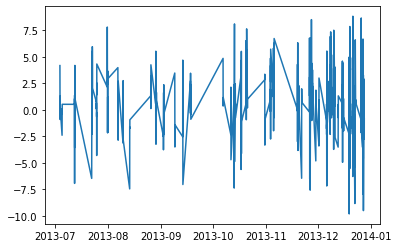

In [1110]:
(y_true - y_pred) / y_true)

In [1116]:
(-_1111 / b_2013_second_half_.mean(axis=1)).mean()

0.09567482673004674

In [1092]:
delta_kwh_second_half_lows_comfortable = delta_kwh_second_half_

In [1093]:
print('normal adversity:', delta_kwh_second_half_normals_adversity.mean().mean())
print('normal affluent:', delta_kwh_second_half_normals_affluent.mean().mean())
print('high comfortable:', delta_kwh_second_half_highs_comfortable.mean().mean())
print('normal comfortable:', delta_kwh_second_half_normals_comfortable.mean().mean())
print('low comfortable:', delta_kwh_second_half_lows_comfortable.mean().mean())

normal adversity: 0.006869548430653894
normal affluent: 0.0016446464254038678
high comfortable: 0.010276869291156707
normal comfortable: 0.006090111959407801
low comfortable: -0.009244370405231265


In [785]:
print('low adversity:', delta_kwh_second_half_lows_adversity.mean().mean())
print('high adversity:', delta_kwh_second_half_highs_adversity.mean().mean())
print('low affluent:', delta_kwh_second_half_lows_affluent.mean().mean())
print('high affluent:', delta_kwh_second_half_highs_affluent.mean().mean())

low adversity: 0.0060448168187456465
high adversity: 0.010777447587446988
low affluent: 0.0027553205160025687
high affluent: 0.014682159072969703


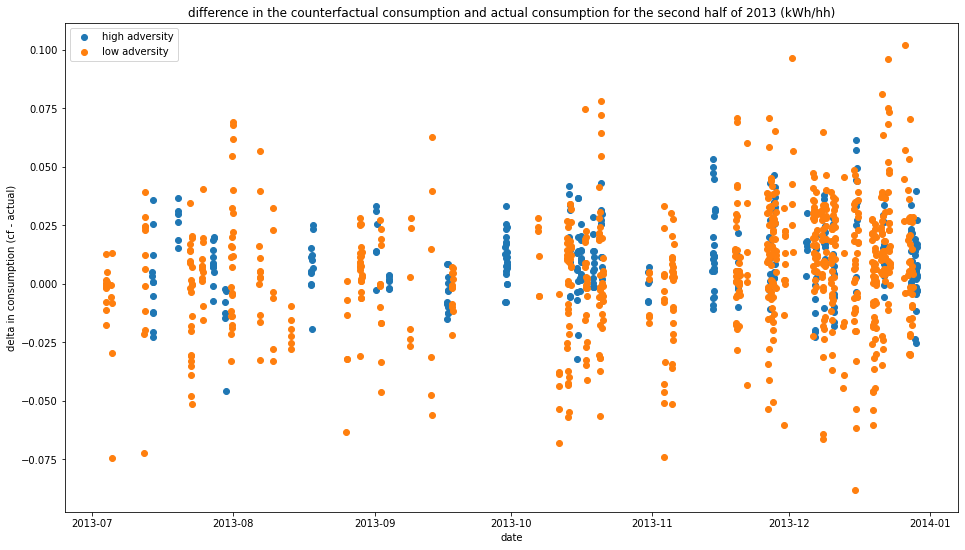

In [784]:
plt.figure(figsize=(16, 9))
plt.scatter(delta_kwh_second_half_highs_adversity.index, delta_kwh_second_half_highs_adversity.mean(axis=1), label='high adversity')
plt.scatter(delta_kwh_second_half_lows_adversity.index, delta_kwh_second_half_lows_adversity.mean(axis=1), label='low adversity')
plt.xlabel('date')
plt.ylabel('delta in consumption (cf - actual)')
plt.title('difference in the counterfactual consumption and actual consumption for the second half of 2013 (kWh/hh)')
plt.legend()
plt.show()

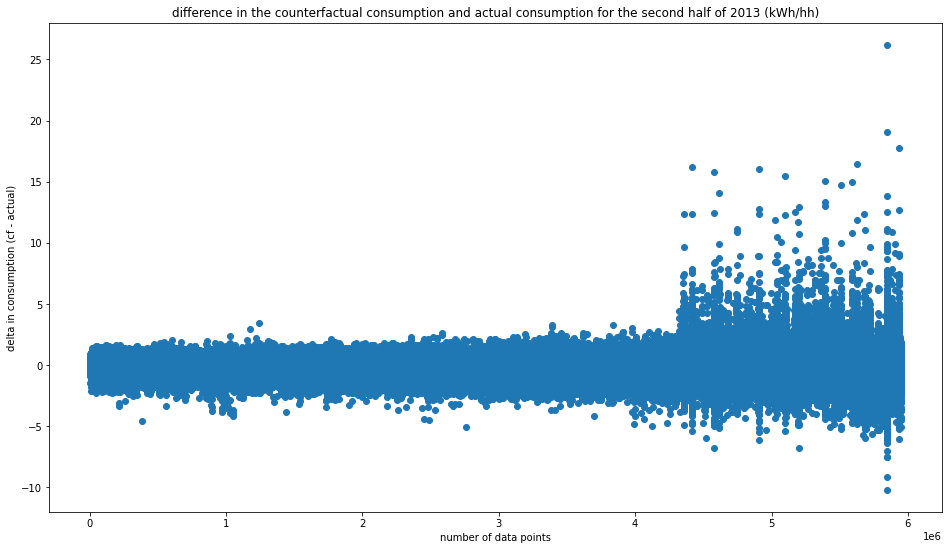

In [654]:
plt.figure(figsize=(16, 9))
plt.scatter(np.arange(0, delta_kwh_second_half_.shape[0] * delta_kwh_second_half_.shape[1]), delta_kwh_second_half_.values.flatten())
plt.xlabel('number of data points')
plt.ylabel('delta in consumption (cf - actual)')
plt.title('difference in the counterfactual consumption and actual consumption for the second half of 2013 (kWh/hh)')
plt.show()

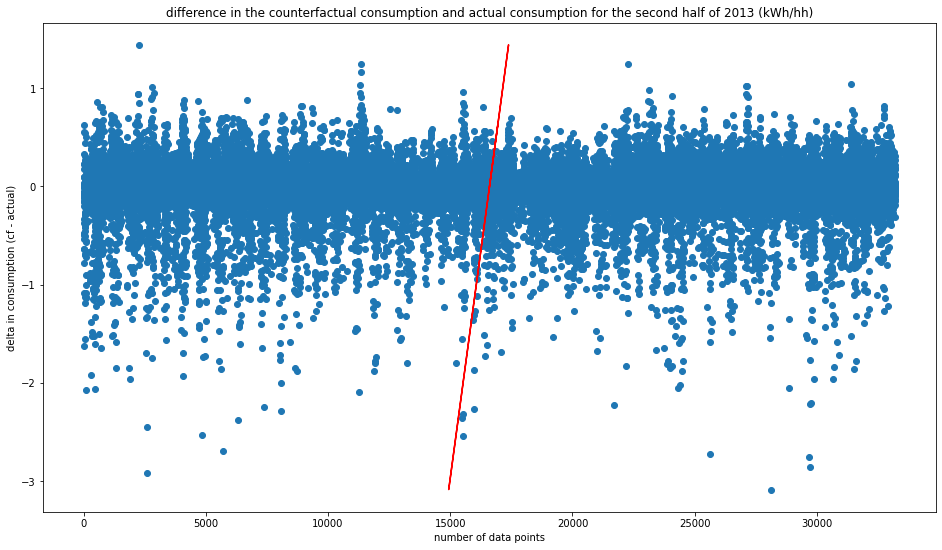

In [701]:
X = delta_kwh_second_half_.values.flatten().reshape(-1, 1)
Y = np.arange(0, delta_kwh_second_half_.shape[0] * delta_kwh_second_half_.shape[1]).reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_linreg = linear_regressor.predict(X)

plt.figure(figsize=(16, 9))
plt.scatter(Y, X)
plt.plot(Y_linreg, X, 'r')
plt.xlabel('number of data points')
plt.ylabel('delta in consumption (cf - actual)')
plt.title('difference in the counterfactual consumption and actual consumption for the second half of 2013 (kWh/hh)')
plt.show()

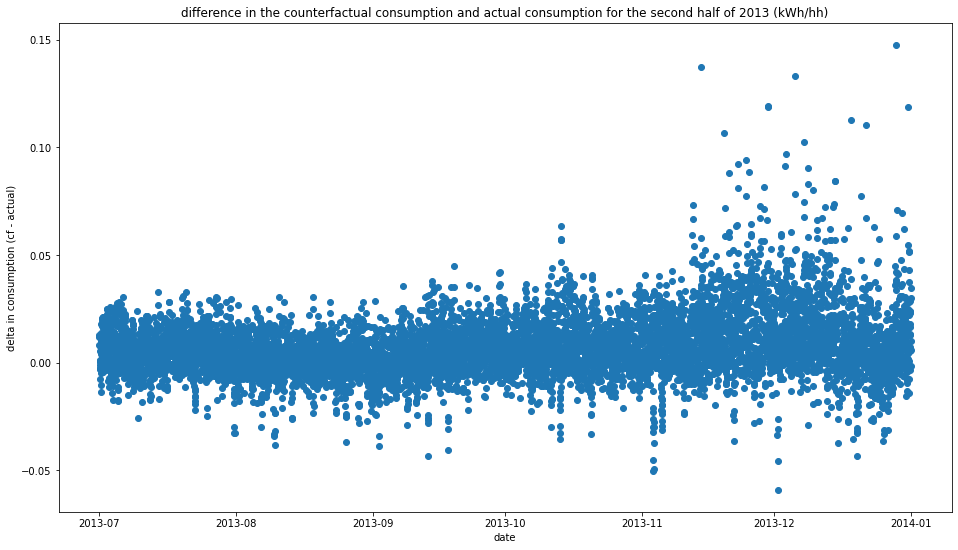

In [655]:
plt.figure(figsize=(16, 9))
plt.scatter(delta_kwh_second_half_.index, delta_kwh_second_half_.mean(axis=1))
plt.xlabel('date')
plt.ylabel('delta in consumption (cf - actual)')
plt.title('difference in the counterfactual consumption and actual consumption for the second half of 2013 (kWh/hh)')
plt.show()

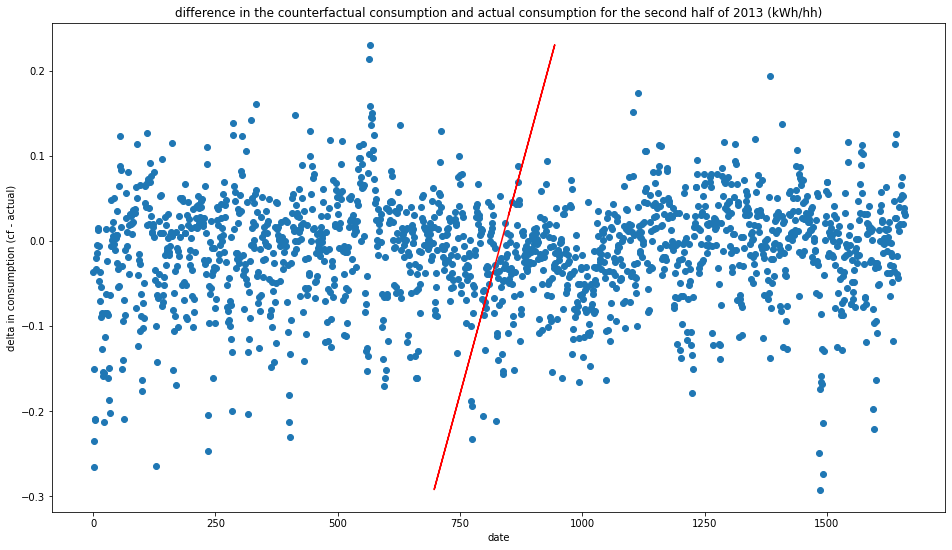

In [717]:
X = delta_kwh_second_half_.mean(axis=1).to_numpy().reshape(-1, 1)
Y = np.arange(0, delta_kwh_second_half_.shape[0]).reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_linreg = linear_regressor.predict(X)

plt.figure(figsize=(16, 9))
plt.scatter(Y, X)
plt.plot(Y_linreg, X, 'r')
plt.xlabel('date')
plt.ylabel('delta in consumption (cf - actual)')
plt.title('difference in the counterfactual consumption and actual consumption for the second half of 2013 (kWh/hh)')
plt.show()

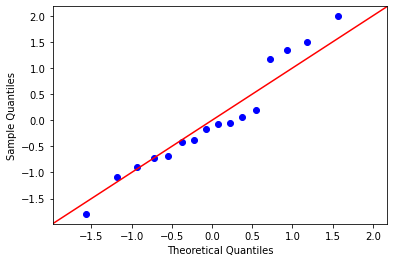

In [726]:
>>> import statsmodels.api as sm
>>> from matplotlib import pyplot as plt
>>> data = sm.datasets.longley.load()
>>> exog = sm.add_constant(data.exog)
>>> mod_fit = sm.OLS(data.endog, exog).fit()
>>> res = mod_fit.resid # residuals
>>> import scipy.stats as stats
>>> fig = sm.qqplot(res, stats.t, fit=True, line="45")
>>> plt.show()

- alpha_2014 X = beta_2014
- alpha_2013 X = beta_cf_2013

dims: 
    (t x n_c) (n_c x n_t) = (t x n_t)
    
- clean data for each year over the house dimension
- intersection of houses between the two years after cleaning
- intersection of time between the control and treatment in the _same_ year

In [15]:
total_usage_2013_sliced = total_usage_2013.loc[(total_usage_2013['date_time'].dt.normalize() <= '2013-02-27')]
total_usage_2014 = total_usage_2014.loc[(total_usage_2014['date_time'].dt.normalize() <= '2014-02-27')]

In [616]:
# move back

print('percentage of missing values in...')
print('control group in 2013', round(a_2013_.isna().sum().sum() / (a_2013_.shape[0] * a_2013_.shape[1]) * 100, 3))
print('treatment group in 2013', round(b_2013_.isna().sum().sum() / (b_2013_.shape[0] * b_2013_.shape[1]) * 100, 3))
print('control group in 2014', round(a_2014_.isna().sum().sum() / (a_2014_.shape[0] * a_2014_.shape[1]) * 100, 3))
print('treatment group in 2014', round(b_2014_.isna().sum().sum() / (b_2014_.shape[0] * b_2014_.shape[1]) * 100, 3))

percentage of missing values in...
control group in 2013 0.019
treatment group in 2013 0.014
control group in 2014 0.02
treatment group in 2014 0.015


In [1178]:
usage_2014_lows_comfortable_jf = get_subset(total_usage_2014, lows_2014, comfortable)
usage_2013_lows_comfortable_jf = get_subset(total_usage_2013_sliced, lows, comfortable)

usage_2014_normals_comfortable_jf = get_subset(total_usage_2014, normals_2014, comfortable)
usage_2013_normals_comfortable_jf = get_subset(total_usage_2013_sliced, normals, comfortable)

usage_2014_highs_comfortable_jf = get_subset(total_usage_2014, highs_2014, comfortable)
usage_2013_highs_comfortable_jf = get_subset(total_usage_2013_sliced, highs, comfortable)

usage_2014_lows_affluent_jf = get_subset(total_usage_2014, lows_2014, affluent)
usage_2013_lows_affluent_jf = get_subset(total_usage_2013_sliced, lows, affluent)

usage_2014_normals_affluent_jf = get_subset(total_usage_2014, normals_2014, affluent)
usage_2013_normals_affluent_jf = get_subset(total_usage_2013_sliced, normals, affluent)

usage_2014_highs_affluent_jf = get_subset(total_usage_2014, highs_2014, affluent)
usage_2013_highs_affluent_jf = get_subset(total_usage_2013_sliced, highs, affluent)

usage_2014_lows_adversity_jf = get_subset(total_usage_2014, lows_2014, adversity)
usage_2013_lows_adversity_jf = get_subset(total_usage_2013_sliced, lows, adversity)

usage_2014_normals_adversity_jf = get_subset(total_usage_2014, normals_2014, adversity)
usage_2013_normals_adversity_jf = get_subset(total_usage_2013_sliced, normals, adversity)

usage_2014_highs_adversity_jf = get_subset(total_usage_2014, highs_2014, adversity)
usage_2013_highs_adversity_jf = get_subset(total_usage_2013_sliced, highs, adversity)

In [1237]:
df_2013_treatment_sliced, df_2013_control_sliced = split_t_c(usage_2013_highs_affluent_jf)
df_2014_treatment, df_2014_control = split_t_c(usage_2014_highs_affluent_jf)

In [1238]:
a_2013_, b_2013_, a_2014_, b_2014_ = get_matrices(df_2013_treatment_sliced, 
                                                  df_2013_control_sliced, df_2014_treatment, df_2014_control, 0.01)

before anything (158, 1685) (158, 485) (158, 1518) (158, 457)
after cleaning (158, 1658) (158, 484) (158, 1468) (158, 392)
after house intersection (158, 1463) (158, 390) (158, 1463) (158, 390)


In [1239]:
n = 0

a_2013 = impute(a_2013_.iloc[n:, :].values, np.nanmedian, 1)
b_2013 = impute(b_2013_.iloc[n:, :].values, np.nanmedian, 1)
a_2014 = impute(a_2014_.iloc[n:, :].values, np.nanmedian, 1)
b_2014 = impute(b_2014_.iloc[n:, :].values, np.nanmedian, 1)

In [1240]:
a_2014_inv = np.linalg.pinv(a_2014)
X = a_2014_inv @ b_2014
b_2013_tilde_jan_feb = a_2013 @ X

In [1241]:
b_2013_tilde_jan_feb_ = pd.DataFrame(b_2013_tilde_jan_feb, columns=b_2013_.iloc[n:, :].columns, index=b_2013_.iloc[n:, :].index)

In [1242]:
print(((b_2013_.mean(axis=1) - b_2013_tilde_jan_feb_.mean(axis=1)) / b_2013_.mean(axis=1)).mean())

-0.029588028623703393


In [642]:
delta_kwh_first_quarter_ = b_2013_tilde_jan_feb_ - b_2013_
# (y_true - y_pred) / y_true
# delta_kwh_first_quarter_.isna().sum().sum()

In [139]:
delta = (b_2013.mean(axis=1)-b_2013_tilde.mean(axis=1)) / b_2013_tilde.mean(axis=1)*100

In [142]:
delta = (b_2013_tilde.mean(axis=1)-b_2013.mean(axis=1)) / b_2013.mean(axis=1)*100

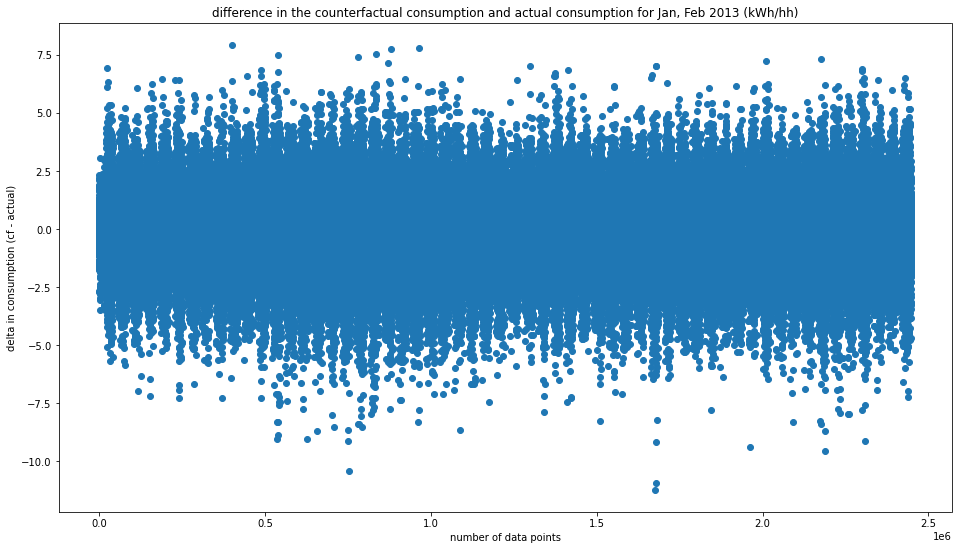

In [643]:
plt.figure(figsize=(16, 9))
plt.scatter(np.arange(0, delta_kwh_first_quarter_.shape[0] * delta_kwh_first_quarter_.shape[1]), delta_kwh_first_quarter_.values.flatten())
plt.xlabel('number of data points')
plt.ylabel('delta in consumption (cf - actual)')
plt.title('difference in the counterfactual consumption and actual consumption for Jan, Feb 2013 (kWh/hh)')
plt.show()

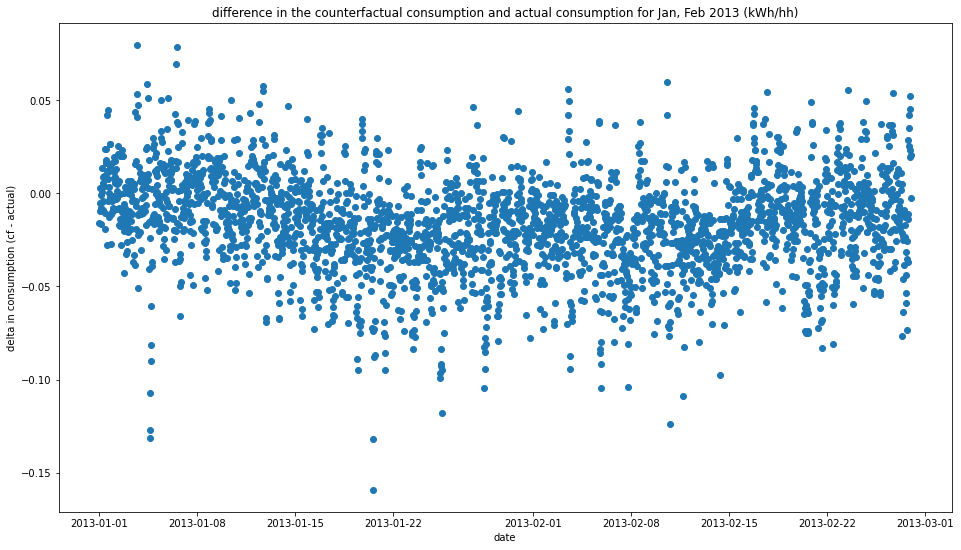

In [622]:
plt.figure(figsize=(16, 9))
plt.scatter(delta_kwh_first_quarter_.index, delta_kwh_first_quarter_.mean(axis=1))
plt.xlabel('date')
plt.ylabel('delta in consumption (cf - actual)')
plt.title('difference in the counterfactual consumption and actual consumption for Jan, Feb 2013 (kWh/hh)')
plt.show()

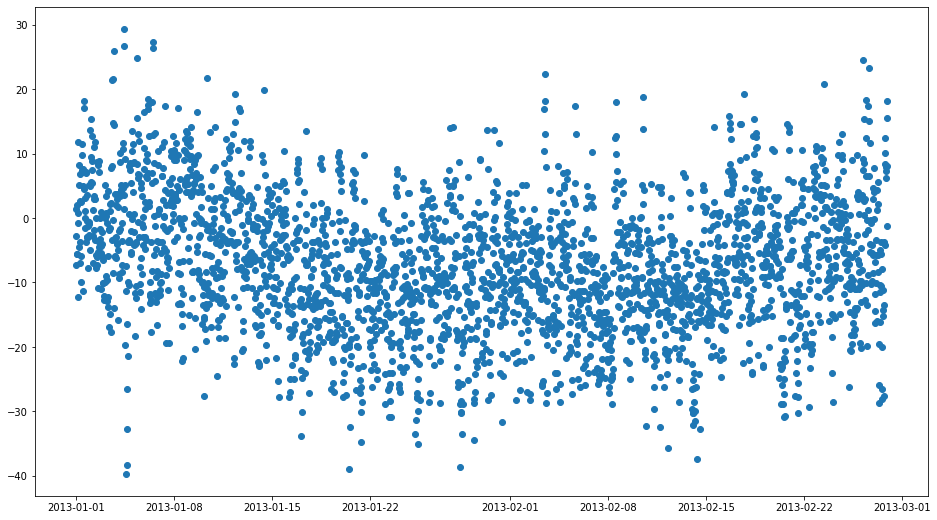

In [143]:
plt.figure(figsize=(16, 9))
plt.scatter(b_2013_.index, delta);

In [209]:
total_usage_2014['hour'] = total_usage_2014['date_time'].dt.hour

In [263]:
# time_of_day_2014 = total_usage_2014.groupby([total_usage_2014['hour'], total_usage_2014['treated']])['KWH/hh'].mean()
time_of_day_2014 = total_usage_2014.groupby([total_usage_2014['hour']])['KWH/hh'].mean()

In [376]:
len(a_2014_.mean(axis=1).values)

2784

In [36]:
def func(x, a, b, c, d):
    return [a * math.sin(b*x_i*math.pi/24 + c) + a * math.sin(b*x_i*math.pi/12) + d for x_i in x]

In [37]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(((y_true - y_pred) / y_true))))*100

In [833]:
# time series prediction on 2014 data
print('2014 control:', find_error_on_timeseries_consumption_model(a_2014_))
print('2014 treatment:', find_error_on_timeseries_consumption_model(b_2014_))
print('2013 control jan, feb:', find_error_on_timeseries_consumption_model(a_2013_))
print('2013 control second half:', find_error_on_timeseries_consumption_model(a_2013_second_half_))
print('2012 control second half:', find_error_on_timeseries_consumption_model(a_2012_second_half_))
print('2012 treatment second half:', find_error_on_timeseries_consumption_model(b_2012_second_half_))

2014 control: 47.13483821438092
2014 treatment: 64.49959036160107
2013 control jan, feb: 41.255428888882605
2013 control second half: 97.63670397861792
2012 control second half: 91.95618144998471
2012 treatment second half: 124.42547832081365


In [832]:
# find the error on the timeseries consumption model
def find_error_on_timeseries_consumption_model(mat):
    ydata = mat.mean(axis=1).values
    xdata = np.arange(0, len(ydata))
#     popt, _ = curve_fit(func, xdata, ydata, p0=(-0.08, 0.25, 0, 0.26))
    yguess = func(xdata, *popt)
    
    return rmspe(ydata, yguess)

In [18]:
temp = pd.read_csv('POWER_Point_Hourly_20120101_20140228_051d5072N_000d1276E_LST_no_header.csv', usecols=['YEAR', 'MO', 'DY', 'HR', 'T2M'])
temp.columns = ['year', 'month', 'day', 'hour', 'temp']
temp['DT'] = pd.to_datetime(temp[['year', 'month', 'day', 'hour']])
temp.set_index('DT', inplace=True)

# remove feb 29, 2012
temp = temp.loc[(temp.index != '2012-02-29')]

temp.head()

,year,month,day,hour,temp
DT,,,,,
2012-01-01 00:00:00,2012,1,1,0,11.12
2012-01-01 01:00:00,2012,1,1,1,11.06
2012-01-01 02:00:00,2012,1,1,2,11.00
2012-01-01 03:00:00,2012,1,1,3,10.99
2012-01-01 04:00:00,2012,1,1,4,10.96


In [969]:
def f(x, a, b, c):
    return a/(x+b) + c

In [1244]:
X = T
Y = residuals_daily.values

popt, _ = curve_fit(f, X, Y, bounds=(0, [50, 400, 400]))
popt

array([5.61037306e+00, 5.53994590e-13, 6.04345240e-18])

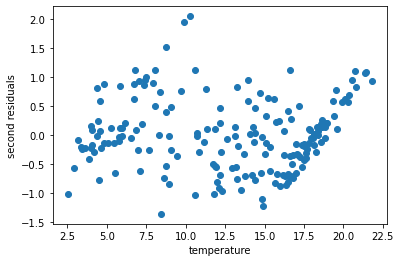

In [1003]:
plt.scatter(X, Y - Y_linreg.reshape(1, -1)[0])
plt.xlabel('temperature')
plt.ylabel('second residuals');

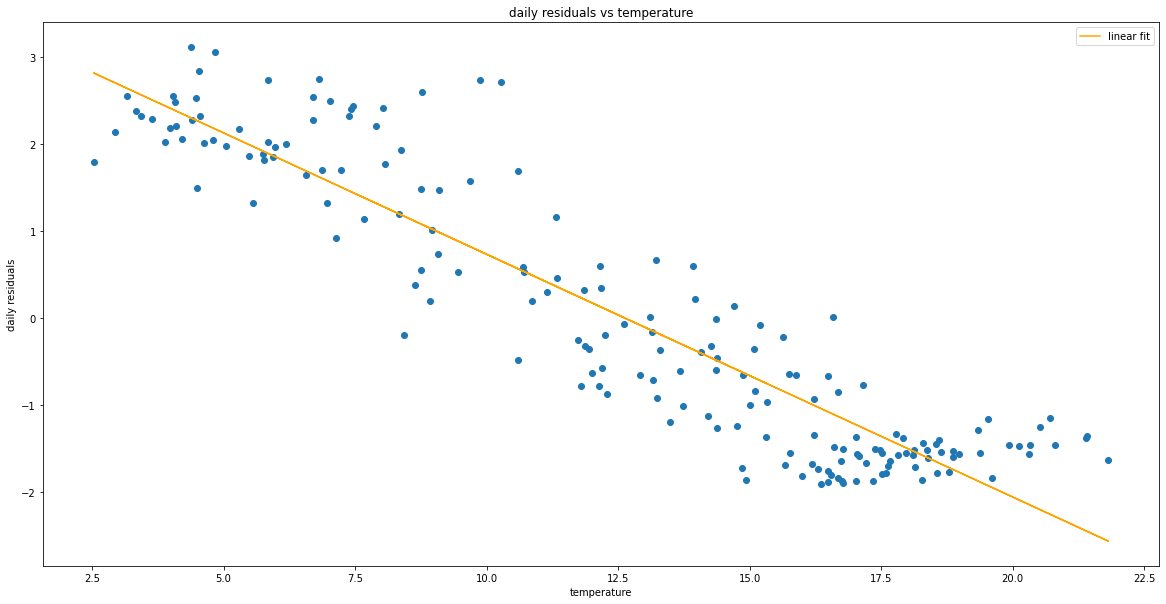

In [1247]:
linear_regressor.fit(X.to_numpy().reshape(-1, 1), Y.reshape(-1, 1))
Y_linreg = linear_regressor.predict(X.to_numpy().reshape(-1, 1))

plt.figure(figsize=(20, 10))
plt.scatter(X, Y)
# plt.plot(X, f(X, *popt), 'r', label='inverse fit')
plt.plot(X, Y_linreg, 'orange', label='linear fit')
plt.xlabel('temperature')
plt.ylabel('daily residuals')
plt.title('daily residuals vs temperature')
plt.legend()
plt.show()

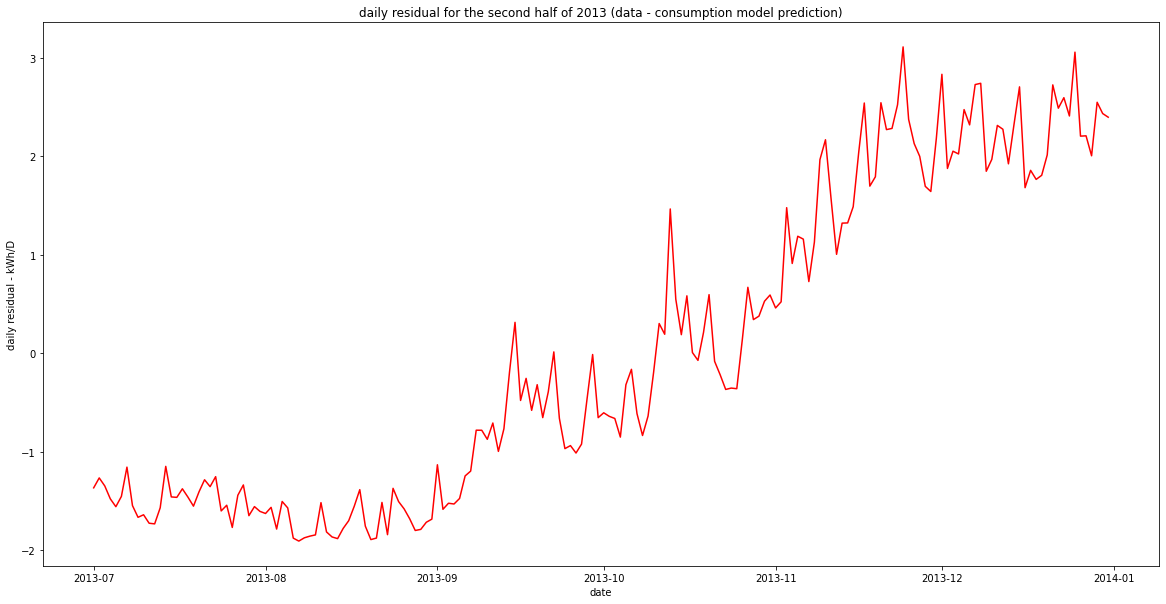

In [951]:
# ydata = a_2014_.mean(axis=1).values
# xdata = np.arange(0, len(ydata))
# popt, _ = curve_fit(func, xdata, ydata, p0=(-0.08, 0.25, 0, 0.26))
# yguess = func(xdata, *popt)

plt.subplots(figsize=(20, 10))
plt.plot(residuals_daily, 'r')
plt.xlabel('date')
plt.ylabel('daily residual - kWh/D')
plt.title('daily residual for the second half of 2013 (data - consumption model prediction)')
plt.show()

In [1015]:
len(residuals_daily.diff())

184

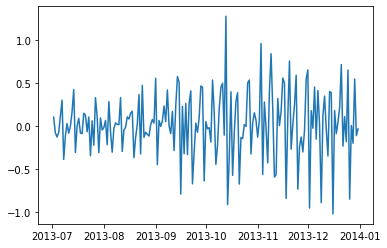

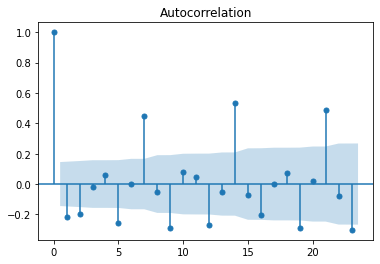

In [1034]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# d = 1
plt.plot(residuals_daily.diff())
plot_acf(residuals_daily.diff().dropna());

In [1038]:
from statsmodels.tsa.arima.model import ARIMA

# (p, d, q=1 confused a lil but ACF, it's okay)

# 1,1,2 ARIMA Model
model = ARIMA(residuals_daily, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              residuals   No. Observations:                  184
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -64.010
Date:                Wed, 16 Mar 2022   AIC                            134.020
Time:                        10:42:55   BIC                            143.648
Sample:                    07-01-2013   HQIC                           137.923
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3709      0.139      2.670      0.008       0.099       0.643
ma.L1         -0.7342      0.100     -7.371      0.000      -0.929      -0.539
sigma2         0.1177      0.010     11.701      0.0

/Users/sabanejad/Projects/demand-response/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/sabanejad/Projects/demand-response/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/sabanejad/Projects/demand-response/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


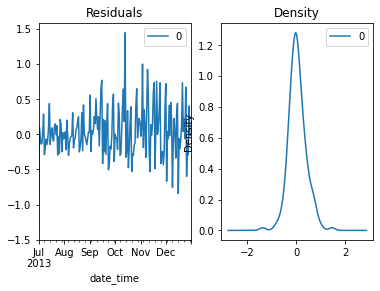

In [1039]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

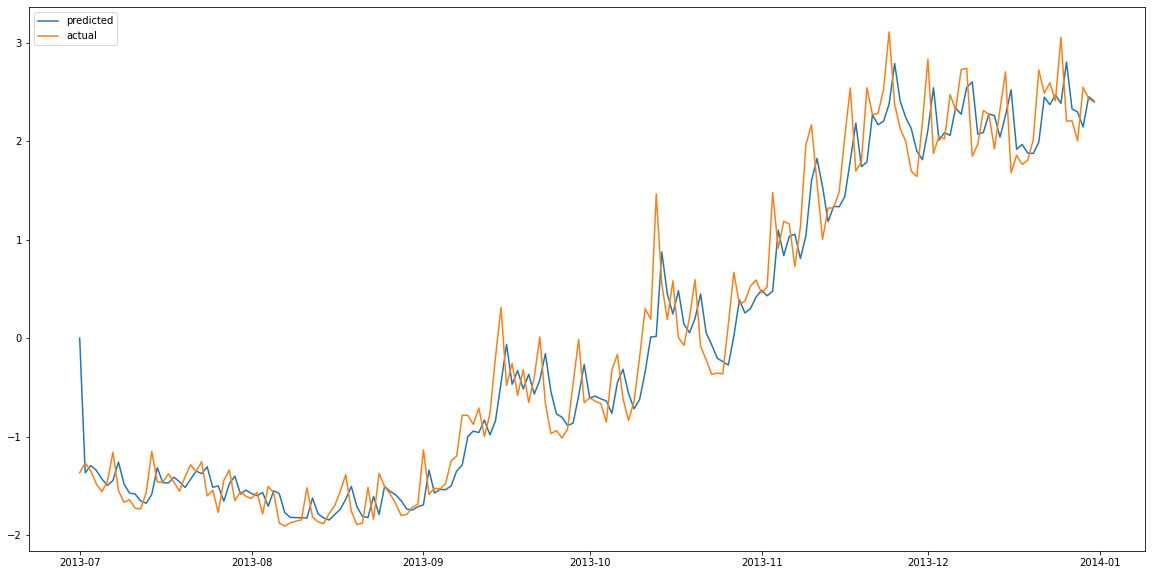

In [1045]:
# Actual vs Fitted
plt.subplots(figsize=(20, 10))
plt.plot(model_fit.predict(), label='predicted')
plt.plot(residuals_daily, label='actual')
plt.legend()
plt.show()

In [1019]:
from pmdarima.arima.utils import ndiffs
# idk wtf this is -- read

## Adf Test
print(ndiffs(residuals_daily, test='adf'))  # 2

# KPSS test
print(ndiffs(residuals_daily, test='kpss'))  # 0

# PP test:
print(ndiffs(residuals_daily, test='pp'))  # 2

1
1
0


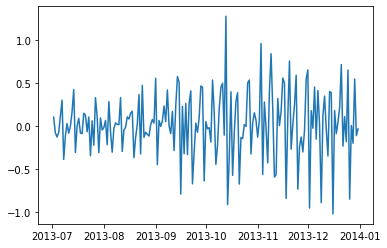

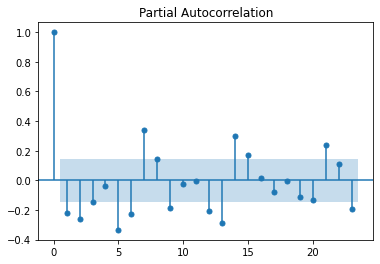

In [1032]:
# p = 1
plt.plot(residuals_daily.diff());
plot_pacf(residuals_daily.diff().dropna());

In [1046]:
train = residuals_daily[:140]
test = residuals_daily[140:]

/Users/sabanejad/Projects/demand-response/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/sabanejad/Projects/demand-response/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/sabanejad/Projects/demand-response/venv/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To si

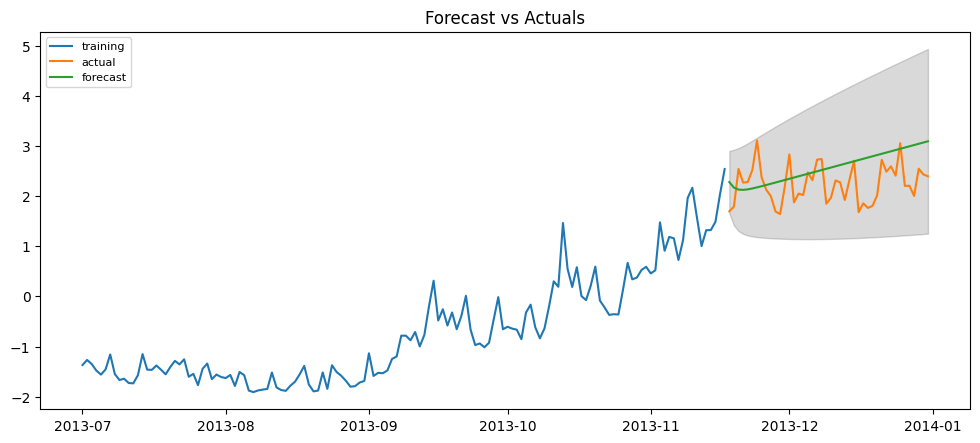

In [1051]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(44, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [923]:
residuals = pd.DataFrame({'residuals': ydata-yguess, 'date_time': a_2013_second_half_.index})
residuals_daily = residuals.groupby(residuals['date_time'].dt.normalize())['residuals'].sum()

In [828]:
test = np.arange(0, 48, 1)
result = np.repeat(test[np.newaxis,...], 100, axis=0).flatten()

array([ 0,  1,  2, ..., 45, 46, 47])

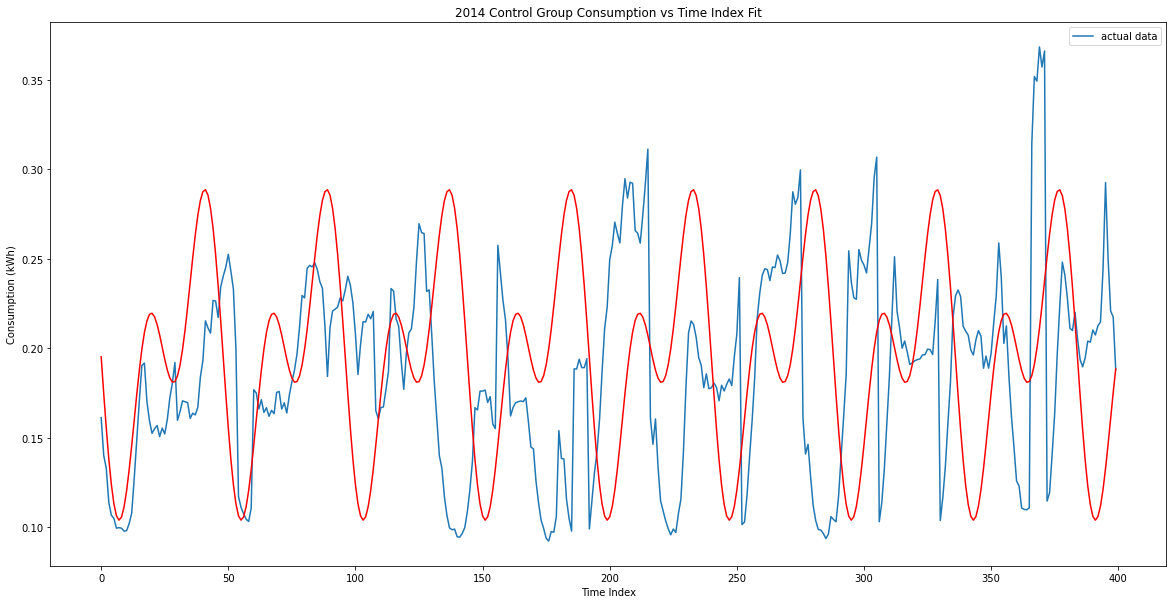

In [1123]:
ydata = a_2013_second_half_.mean(axis=1).values[:400]
xdata = np.arange(0, len(ydata))
yguess = func(xdata, -0.05251314, 1.0001539, 0.05238265, 0.19800201)

plt.subplots(figsize=(20, 10))
plt.plot(xdata, ydata, label='actual data')
# plt.plot(xdata, yguess, 'r', label='guess data')
plt.plot(xdata, yguess, 'r')
plt.title('2014 Control Group Consumption vs Time Index Fit')
plt.xlabel('Time Index')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.show()

In [41]:
total_usage_2013.loc[~total_usage_2013['treated']].groupby(total_usage_2013['date_time'])['KWH/hh'].mean()

date_time
2013-01-01 00:00:00    0.261270
2013-01-01 00:30:00    0.240669
2013-01-01 01:00:00    0.219610
2013-01-01 01:30:00    0.201582
2013-01-01 02:00:00    0.184829
                         ...   
2013-12-31 21:30:00    0.312304
2013-12-31 22:00:00    0.295147
2013-12-31 22:30:00    0.282948
2013-12-31 23:00:00    0.266107
2013-12-31 23:30:00    0.251079
Name: KWH/hh, Length: 17520, dtype: float64

[-0.05909612  1.00009907  0.05407426  0.21419654]


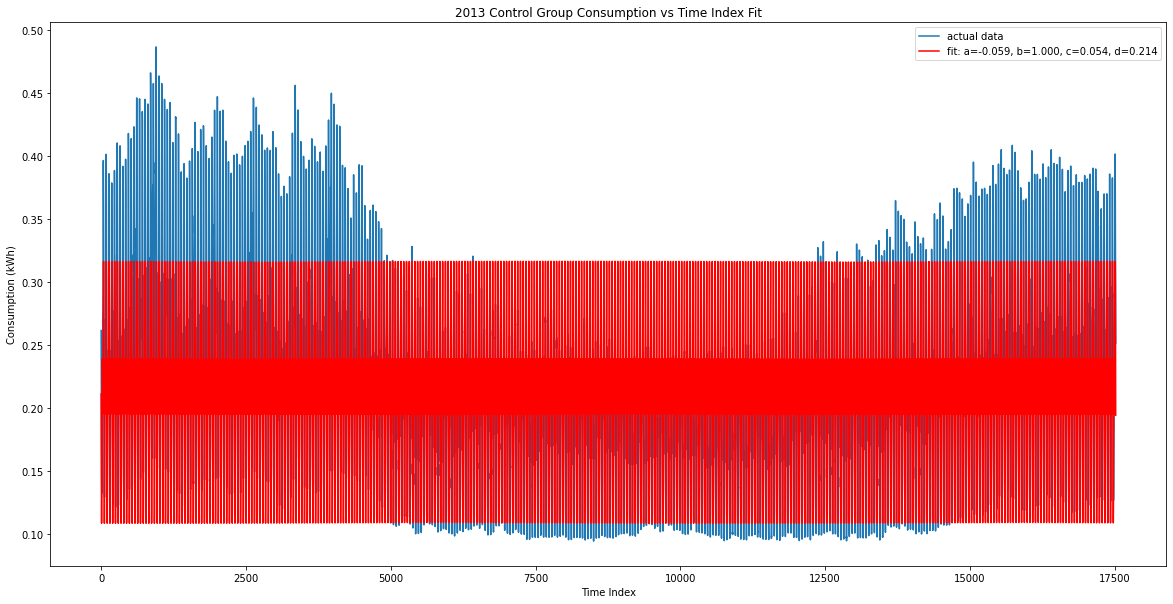

In [42]:
ydata = _41.values
xdata = np.arange(0, len(ydata))
popt, _ = curve_fit(func, xdata, ydata, p0=(-0.08, 1, 0, 0.26))
print(popt)
yguess = func(xdata, *popt)
# yguess = func(xdata, -0.08, 0.25, 0, 0.26)

plt.subplots(figsize=(20, 10))
plt.plot(xdata, ydata, label='actual data')
# plt.plot(xdata, yguess, 'r', label='guess data')
plt.plot(xdata, yguess, 'r', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
plt.title('2013 Control Group Consumption vs Time Index Fit')
plt.xlabel('Time Index')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.show()

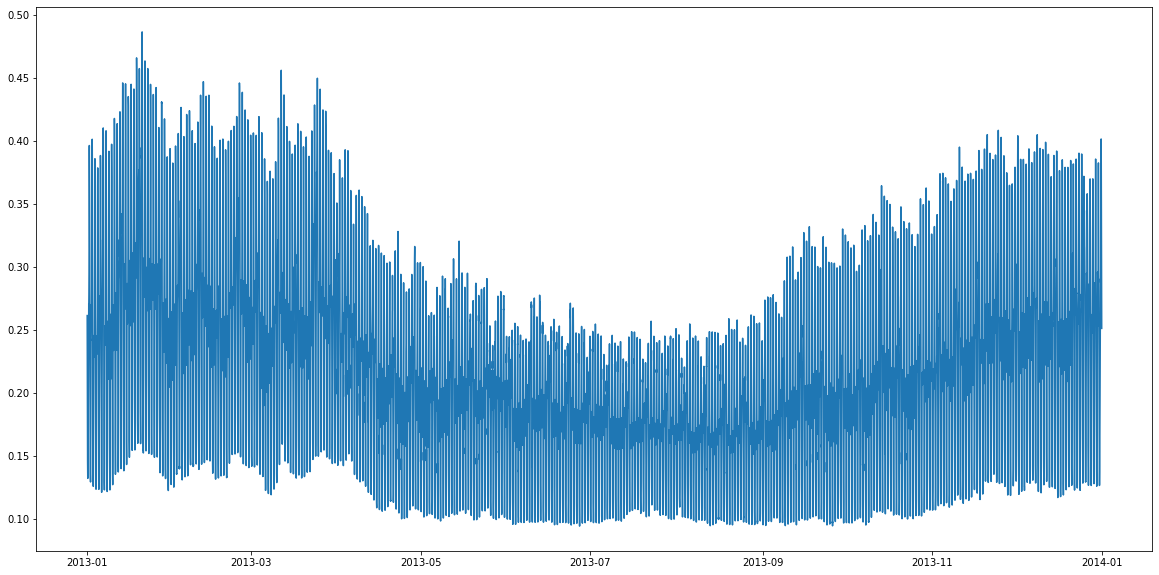

In [52]:
plt.subplots(figsize=(20, 10))
plt.plot(_41, label='actual data')
plt.show()

[-0.05251314  1.0001539   0.05238265  0.19800201]


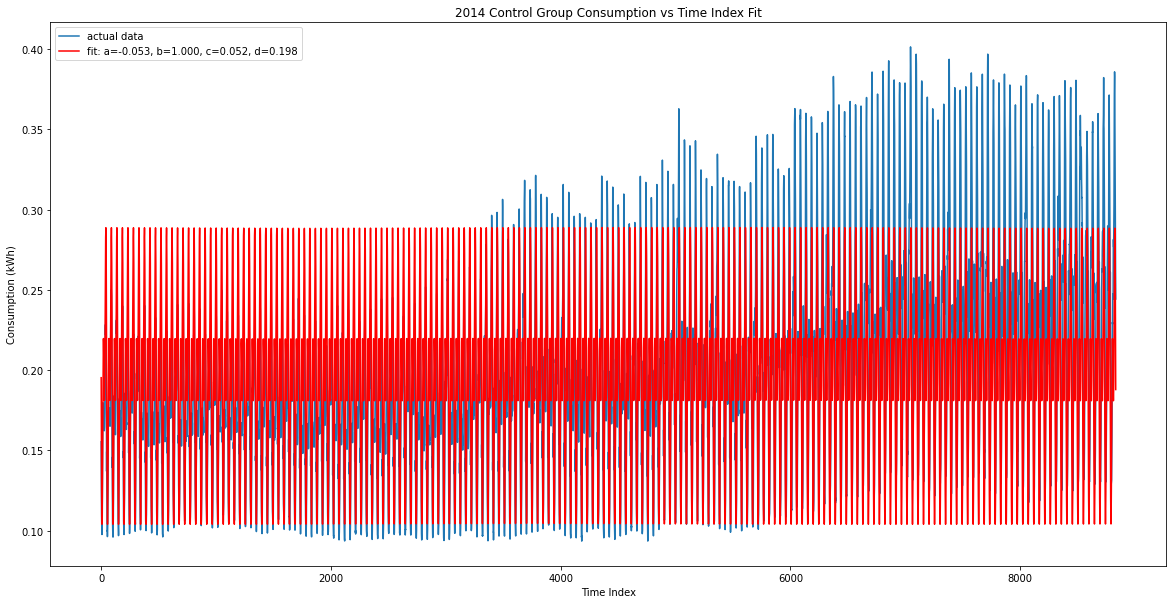

In [920]:
ydata = a_2013_second_half_.mean(axis=1).values
xdata = np.arange(0, len(ydata))
popt, _ = curve_fit(func, xdata, ydata, p0=(-0.08, 1, 0, 0.26))
print(popt)
yguess = func(xdata, *popt)
# yguess = func(xdata, -0.08, 0.25, 0, 0.26)

plt.subplots(figsize=(20, 10))
plt.plot(xdata, ydata, label='actual data')
# plt.plot(xdata, yguess, 'r', label='guess data')
plt.plot(xdata, yguess, 'r', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
plt.title('2014 Control Group Consumption vs Time Index Fit')
plt.xlabel('Time Index')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.show()

In [813]:
popt, _ = curve_fit(func, xdata, ydata, p0=(-0.08, 0.25, 0, 0.26))
# , bounds=[(0.01, 1, 0.08, -math.inf, -math.inf, -math.inf), (0.9, math.inf, 2, math.inf, math.inf, math.inf)])
popt

array([ 0.00379567,  0.24926718, -0.5007797 ,  0.24240288])

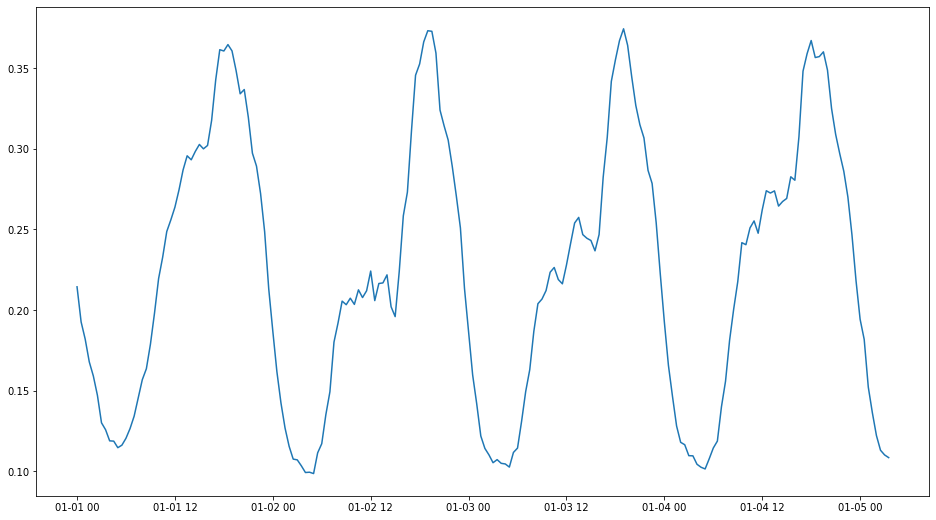

In [479]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))
# plt.plot(b_2013_tilde.mean(axis=1)[:500])
# plt.plot(b_2013.mean(axis=1)[:500])
plt.plot(b_2014_.mean(axis=1)[:200]);

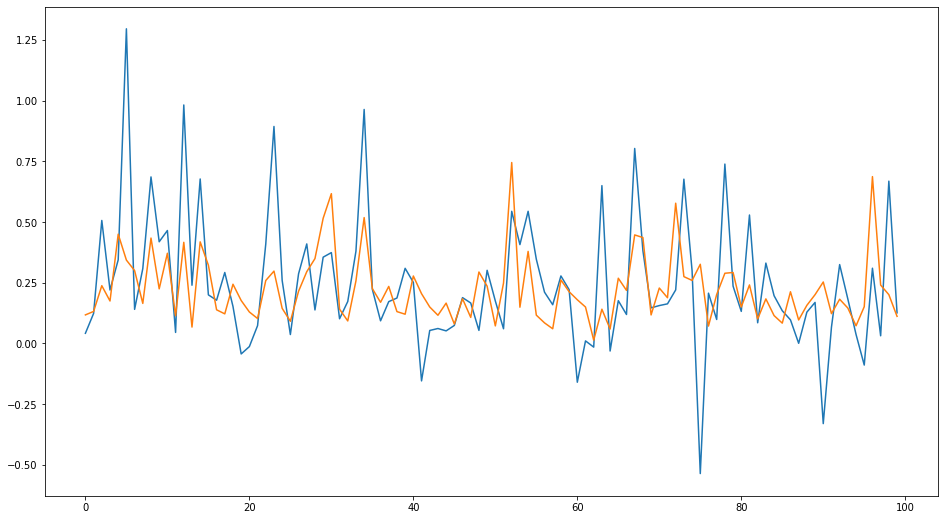

In [117]:
plt.figure(figsize=(16, 9))
plt.plot(b_2013_tilde.mean(axis=0)[:100])
plt.plot(b_2013.mean(axis=0)[:100])

In [668]:
def get_subset(df, time, socio):
    df_mod = df.loc[df['date_time'].isin(time)]
    return df_mod.loc[df_mod['house_id'].isin(socio)]

In [786]:
usage_2012_lows_comfortable = get_subset(total_usage_2012_second_half, lows_2012, comfortable)
usage_2013_lows_comfortable = get_subset(total_usage_2013_second_half, lows, comfortable)

usage_2012_normals_comfortable = get_subset(total_usage_2012_second_half, normals_2012, comfortable)
usage_2013_normals_comfortable = get_subset(total_usage_2013_second_half, normals, comfortable)

usage_2012_highs_comfortable = get_subset(total_usage_2012_second_half, highs_2012, comfortable)
usage_2013_highs_comfortable = get_subset(total_usage_2013_second_half, highs, comfortable)

usage_2012_lows_affluent = get_subset(total_usage_2012_second_half, lows_2012, affluent)
usage_2013_lows_affluent = get_subset(total_usage_2013_second_half, lows, affluent)

usage_2012_normals_affluent = get_subset(total_usage_2012_second_half, normals_2012, affluent)
usage_2013_normals_affluent = get_subset(total_usage_2013_second_half, normals, affluent)

usage_2012_highs_affluent = get_subset(total_usage_2012_second_half, highs_2012, affluent)
usage_2013_highs_affluent = get_subset(total_usage_2013_second_half, highs, affluent)

usage_2012_lows_adversity = get_subset(total_usage_2012_second_half, lows_2012, adversity)
usage_2013_lows_adversity = get_subset(total_usage_2013_second_half, lows, adversity)

usage_2012_normals_adversity = get_subset(total_usage_2012_second_half, normals_2012, adversity)
usage_2013_normals_adversity = get_subset(total_usage_2013_second_half, normals, adversity)

usage_2012_highs_adversity = get_subset(total_usage_2012_second_half, highs_2012, adversity)
usage_2013_highs_adversity = get_subset(total_usage_2013_second_half, highs, adversity)

In [ ]:
def get_subset(df, time, socio):
    return mat.loc[mat.index.isin(time), mat.columns.isin(socio)]

In [196]:
highs_affluent = get_subset(highs, affluent)
lows_affluent_delta = get_subset(lows, affluent)

highs_comfortable_delta = get_subset(highs, comfortable)
lows_comfortable_delta = get_subset(lows, comfortable)

highs_adversity_delta = get_subset(highs, adversity)
lows_adversity_delta = get_subset(lows, adversity)

In [488]:
highs_affluent_delta.values.flatten()

array([ -177.80796468, -1480.07059122,   -26.44881328, ...,
         -69.70965394,  -161.20892852,   -32.27495502])

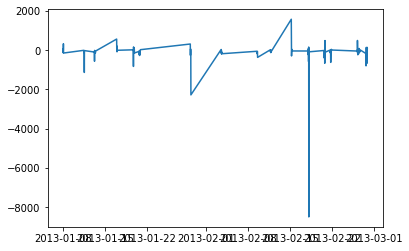

In [495]:
b_2013_.loc[b_2013_.index.isin(time), b_2013_.columns.isin(socio)]